# This notebook is to Implement my solution for the home assignment
* Written by: Yotam Dery
* Sunmission date: 03/17/2024

### Imports

In [1]:
import numpy as np
import pandas as pd
from plot_utils import *
from feature_engineering_utils import calc_bmi_categories, calc_weight_height_ratio, create_age_bins, calc_visit_change, calc_engagement_score

## EDA

### Reading the data file

In [2]:
# Read the data with parse_dates argument
df = pd.read_csv('data_scientist_home_assignment.csv',
                 parse_dates=['EffectiveDate'])
# MemberID column modification
df['MemberID'] = df['MemberID'].str.replace('member_', '', regex=True)

In [3]:
df.head()

,MemberID,EffectiveDate,Age,Gender,Height,Weight,DEXAScanResult,AppUsage,GymVisitsLast2W,GymVisitsLast6W,GymVisitsLast12W,OutReach,OutReachOutcome,ChurnIn30Days
0,0402,2023-01-02,39,F,167.87,47.23,Low Muscle Mass,1.91,1,1,6,1,contacted,0
1,0838,2023-01-02,36,M,171.23,62.25,Normal,0.21,1,2,2,1,contacted,0
2,0532,2023-01-02,46,M,167.91,77.23,High Muscle Mass,1.04,1,3,10,1,left message,0
3,0558,2023-01-02,34,M,154.74,70.38,High Muscle Mass,0.90,1,4,6,1,contacted,0
4,0113,2023-01-02,24,M,169.61,72.29,High Muscle Mass,2.30,3,6,13,0,NaN,0


In [4]:
df.describe()

,Age,Height,Weight,AppUsage,GymVisitsLast2W,GymVisitsLast6W,GymVisitsLast12W,OutReach,ChurnIn30Days
count,5200.000000,5200.000000,5200.000000,5200.000000,5200.000000,5200.000000,5200.000000,5200.000000,5200.000000
mean,41.005962,170.593635,70.372862,2.490615,2.495577,7.485962,14.982308,0.338654,0.120769
std,13.329497,9.778996,14.473021,1.439624,2.134355,5.087293,9.487040,0.473297,0.325890
min,18.000000,145.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,163.987500,60.515000,1.260000,1.000000,3.000000,7.000000,0.000000,0.000000
50%,41.000000,170.380000,70.010000,2.490000,2.000000,7.000000,14.000000,0.000000,0.000000
75%,52.000000,177.080000,79.890000,3.750000,4.000000,11.000000,22.000000,1.000000,0.000000
max,64.000000,201.930000,128.890000,5.000000,15.000000,26.000000,43.000000,1.000000,1.000000


In [5]:
# How many members we have in the df?
print('We have {} distinct members (users) in the df'.format(df['MemberID'].nunique()))

We have 996 distinct members (users) in the df


### Data cleaning

In [6]:
# Check for correct data types
df.dtypes

MemberID                    object
EffectiveDate       datetime64[ns]
Age                          int64
Gender                      object
Height                     float64
Weight                     float64
DEXAScanResult              object
AppUsage                   float64
GymVisitsLast2W              int64
GymVisitsLast6W              int64
GymVisitsLast12W             int64
OutReach                     int64
OutReachOutcome             object
ChurnIn30Days                int64
dtype: object

In [7]:
# Check for any duplications in the data
df.duplicated().sum()
print("The data contains no duplications!")

The data contains no duplications!


#### Handeling missing values

In [8]:
# Check for missing values
missing_values_series = df.isnull().sum()[lambda x: x > 0]
print('Seems like the only feature with missing values is {}, with a count of {} missing values, constitutes {}% of all rows. Lets dive in to that:'.format(missing_values_series.index[0], missing_values_series.iloc[0], np.round(missing_values_series.iloc[0]*100 / df.shape[0], 2)))

Seems like the only feature with missing values is OutReachOutcome, with a count of 3439 missing values, constitutes 66.13% of all rows. Lets dive in to that:


In [9]:
df.groupby(['OutReach', 'OutReachOutcome']).size().unstack()

OutReachOutcome,called member didnt respond,contacted,left message
OutReach,,,
1,570,591,600


In [10]:
print('Count of missing values when OutReach equals to zero is: {}'.format(df[df['OutReach']==0]['OutReachOutcome'].isnull().sum()))

Count of missing values when OutReach equals to zero is: 3439


In [11]:
print("Given the previous 2 cells, all missing values are in the OutReachOutcome feature. Let's visualize that!")

Given the previous 2 cells, all missing values are in the OutReachOutcome feature. Let's visualize that!


In [12]:
# Process the DF
df_outreach_1 = df[df['OutReach'] == 1]
df_outreach_0 = df[df['OutReach'] == 0]
df_outreach_0 = df_outreach_0.fillna('No Outcome')

# Ploting
plot_OutReachOutcome_by_Outreach_Attempt(df_outreach_0, df_outreach_1)


In [13]:
# Assigning an explicit value for the null values
df['OutReachOutcome'] = df['OutReachOutcome'].fillna('not contacted')
if sum(df.isnull().sum()) == 0:
    print ('There are no missing values')

There are no missing values


## Distribution visualizations

### Distribution of categorical features

In [14]:
# Ploting histogram per categorical feature
for cat_feature in ['Gender', 'DEXAScanResult', 'OutReach', 'OutReachOutcome']:
    plot_df = df[['MemberID', cat_feature]].drop_duplicates() if cat_feature in ['Gender', 'DEXAScanResult'] else df
    plot_categorical_feature(plot_df, cat_feature)

In [15]:
# Separately plotting the label distribution
plot_categorical_feature(df, 'ChurnIn30Days')
label_dist = df['ChurnIn30Days'].value_counts()
negative_count = label_dist.iloc[0]
positive_count = label_dist.iloc[1]
positive_percent = np.round(positive_count / (positive_count + negative_count), 2)
print('We can see that the label is imbalanced, with {} positive and {} negative labels. <br> The positive labels constitues {} % of all data'.format(positive_count, negative_count, positive_percent))

We can see that the label is imbalanced, with 628 positive and 4572 negative labels. <br> The positive labels constitues 0.12 % of all data


### Distribution of numerical features

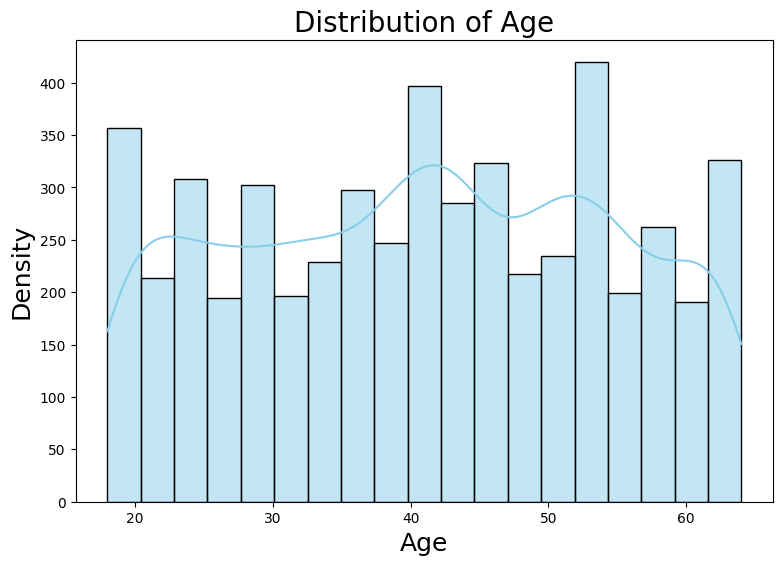

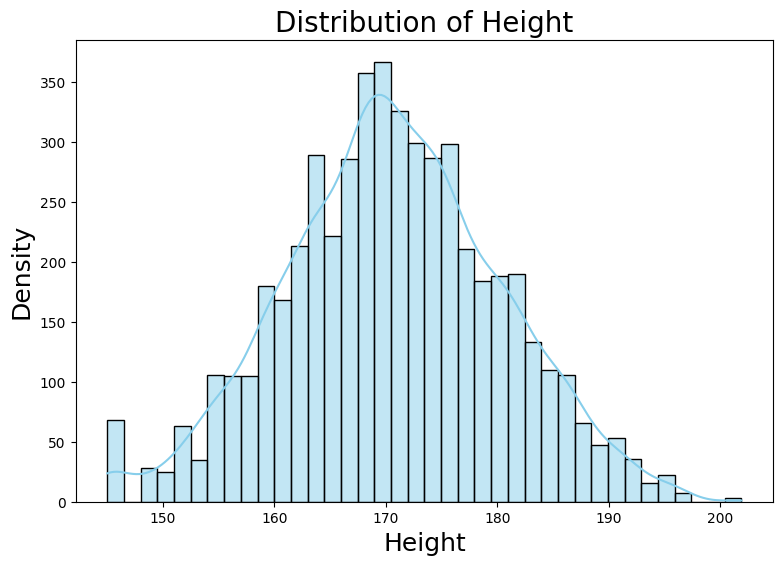

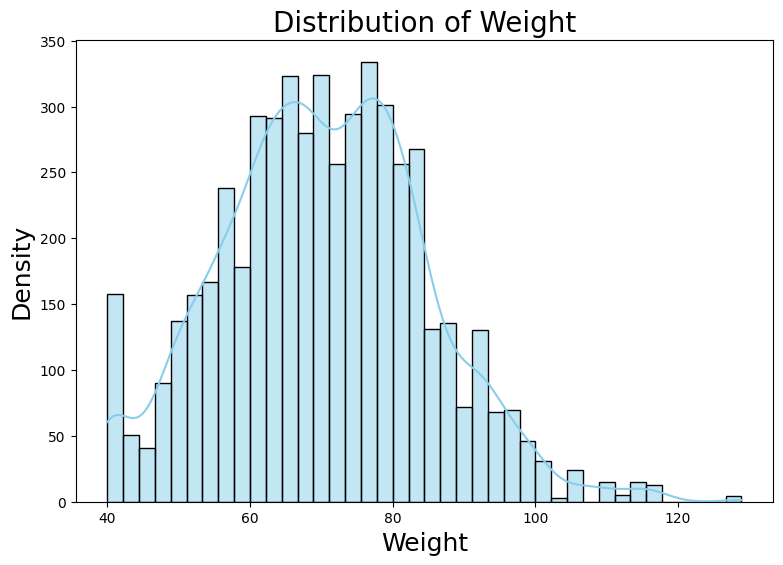

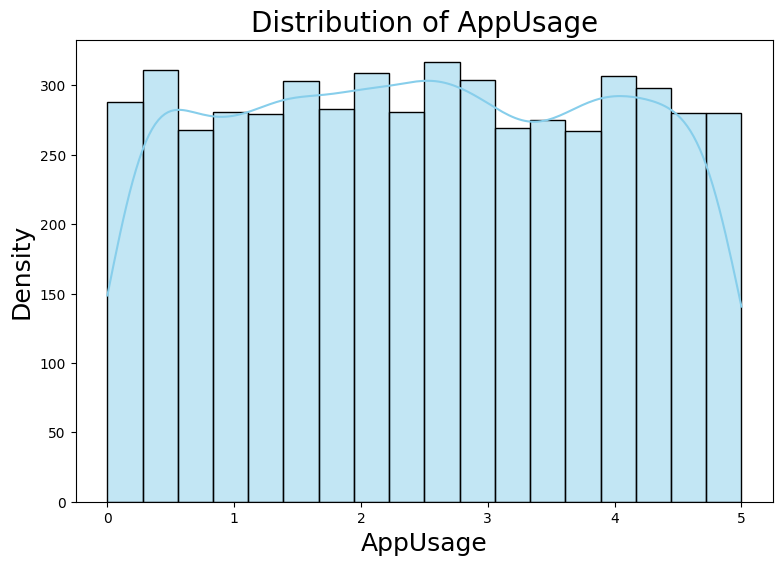

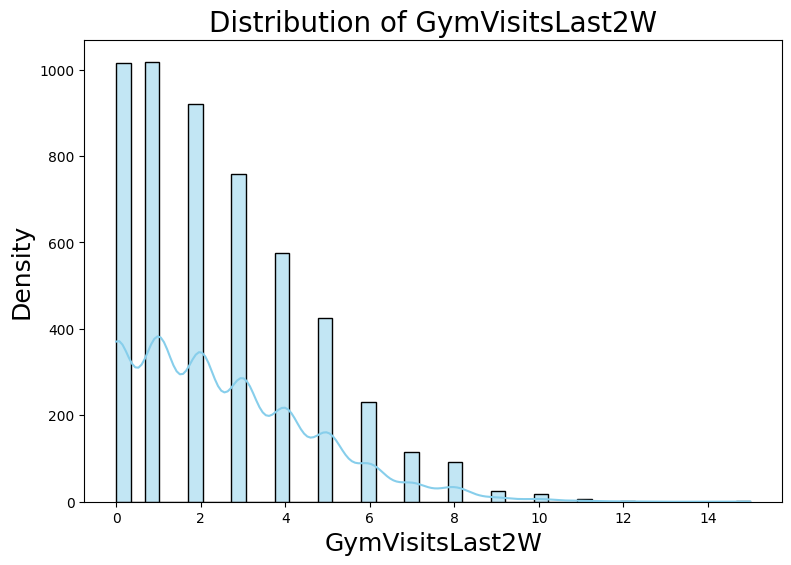

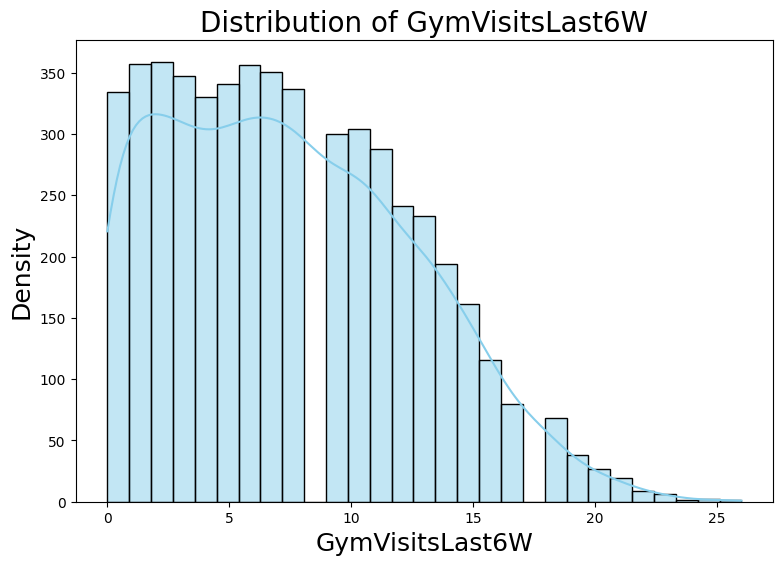

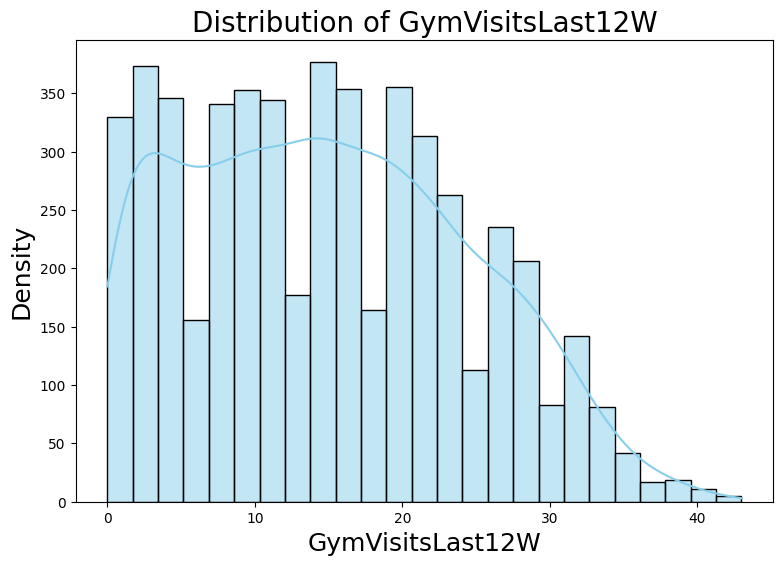

In [16]:
# Plottings
for feature in [
        'Age', 'Height', 'Weight', 'AppUsage', 'GymVisitsLast2W',
        'GymVisitsLast6W', 'GymVisitsLast12W'
]:
    plot_df = df[['MemberID', feature
                  ]] if feature in ['Age', 'Height', 'Weight'] else df
    plot_dist_numerical_features(plot_df, feature)

    

### Correlation for numerical features

In [17]:
# Compute the correlation matrix
correlation_matrix = np.round(df[['Age', 'Height', 'Weight', 'AppUsage', 'GymVisitsLast2W', 'GymVisitsLast6W', 'GymVisitsLast12W']].corr(),2)
plot_corr(correlation_matrix)
print("There is a strong positive correlation between AppUsage and the variables representing gym visits over different periods (GymVisitsLast2W, GymVisitsLast6W, GymVisitsLast12W).\n This suggests that members who use the app more frequently tend to visit the gym more often within these time frames.")

There is a strong positive correlation between AppUsage and the variables representing gym visits over different periods (GymVisitsLast2W, GymVisitsLast6W, GymVisitsLast12W).
 This suggests that members who use the app more frequently tend to visit the gym more often within these time frames.


### Pair plot for correlation numerical features

* Let's proceed with Pairwise Scatter Plots for key variables.<br> Given the strong correlations identified, we'll visualize relationships between AppUsage and GymVisitsLast2W, GymVisitsLast6W, GymVisitsLast12W

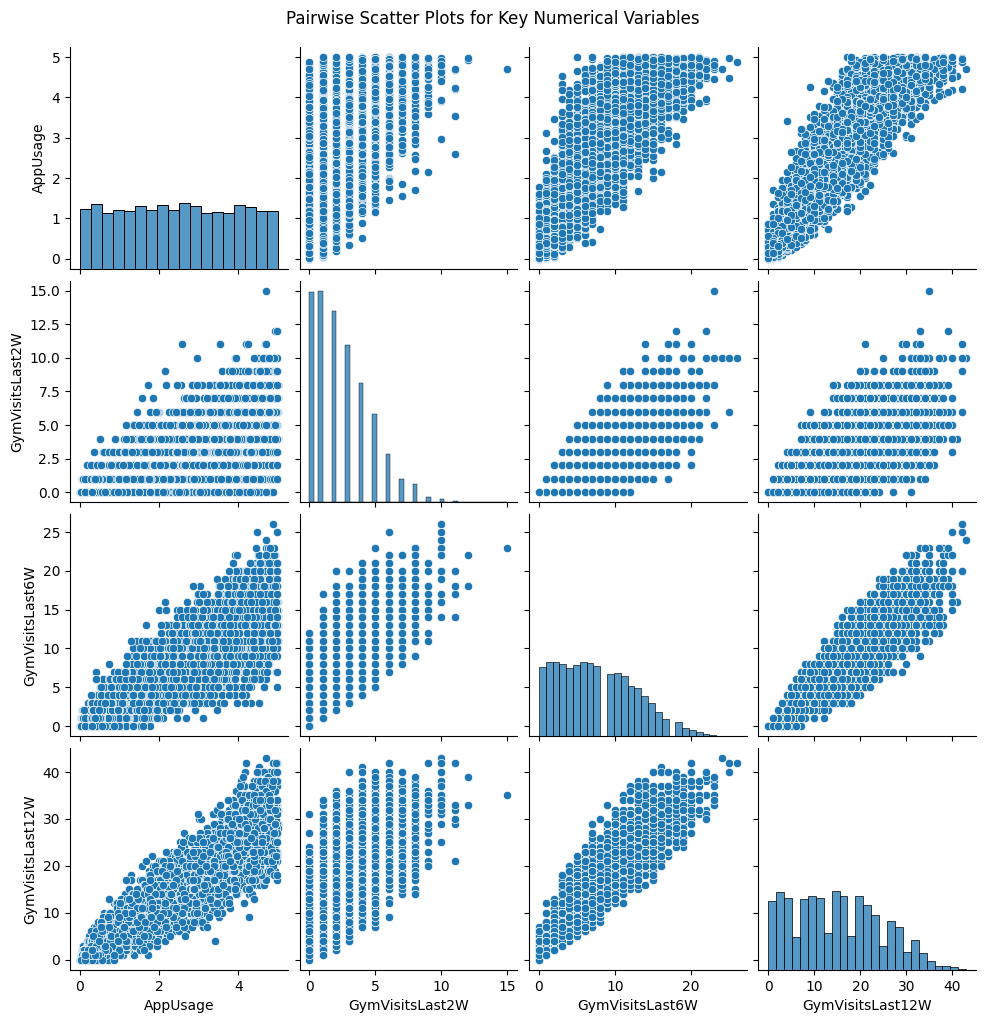

In [18]:
# Select key variables for pairwise scatter plots
key_variables = ['AppUsage', 'GymVisitsLast2W', 'GymVisitsLast6W', 'GymVisitsLast12W']

# Pairwise scatter plots using Seaborn's pairplot
sns.pairplot(df[key_variables])
plt.suptitle("Pairwise Scatter Plots for Key Numerical Variables", y=1.02)  # Add a title and adjust its position
plt.show()

* AppUsage vs GymVisits: There's a noticeable positive relationship between app usage and the number of gym visits over the last 2, 6, and 12 weeks.<br> This aligns with the correlation analysis, indicating that members who use the app more frequently tend to visit the gym more often. <br><br>
* GymVisits Relationships: The scatter plots among GymVisitsLast2W, GymVisitsLast6W, and GymVisitsLast12W demonstrate strong linear relationships, as expected.<br> This suggests consistency in gym attendance over different time frames for many members.

### Grouped Analysis

#### Analysis by Gender

In [19]:
# Perform grouped analysis by 'Gender'
feature_grouped = df.groupby('Gender').agg({
    'Age': ['mean', 'median'],
    'Height': ['mean', 'median'],
    'Weight': ['mean', 'median'],
    'AppUsage': ['mean', 'median'],
    'GymVisitsLast2W': ['mean', 'median'],
    'GymVisitsLast6W': ['mean', 'median'],
    'GymVisitsLast12W': ['mean', 'median']
}).reset_index()

# Prepare the data for plotting
categories = ['Age', 'Height', 'Weight', 'AppUsage', 'GymVisitsLast2W', 'GymVisitsLast6W', 'GymVisitsLast12W']
feature_categories = feature_grouped['Gender']

plot_statistics_by_feature(feature_grouped, categories, feature_categories, feature="Gender")
print("Looking at the plot, we can see that Gender doesn't contribute any additional information, hence we can drop it from our data")

Looking at the plot, we can see that Gender doesn't contribute any additional information, hence we can drop it from our data


In [20]:
df = df.drop(columns="Gender", axis=1)

#### Analysis by DEXAScanResult

In [21]:
# Perform grouped analysis by 'Gender'
gender_grouped = df.groupby('DEXAScanResult').agg({
    'Age': ['mean', 'median'],
    'Height': ['mean', 'median'],
    'Weight': ['mean', 'median'],
    'AppUsage': ['mean', 'median'],
    'GymVisitsLast2W': ['mean', 'median'],
    'GymVisitsLast6W': ['mean', 'median'],
    'GymVisitsLast12W': ['mean', 'median']
}).reset_index()

# Prepare the data for plotting
categories = ['Age', 'Height', 'Weight', 'AppUsage', 'GymVisitsLast2W', 'GymVisitsLast6W', 'GymVisitsLast12W']
gender_categories = gender_grouped['DEXAScanResult']

plot_statistics_by_feature(gender_grouped,
                           categories,
                           gender_categories,
                           feature='DEXAScanResult')
print("Insights:\n")
print("Age: Members with Low Muscle Mass tend to be slightly older on average.\n"
"Height and Weight: There's a noticeable difference in average heights and weights across different DEXA scan results, reflecting the expected physical characteristics associated with each category.\n"
"App Usage: Slightly higher app usage is observed in the Normal and Low Fat Percentage categories.\n"
"Gym Visits: Gym visit patterns show slight variations across different DEXA scan results, with those in the Low Fat Percentage category having slightly higher gym visit counts on average.")

Insights:

Age: Members with Low Muscle Mass tend to be slightly older on average.
Height and Weight: There's a noticeable difference in average heights and weights across different DEXA scan results, reflecting the expected physical characteristics associated with each category.
App Usage: Slightly higher app usage is observed in the Normal and Low Fat Percentage categories.
Gym Visits: Gym visit patterns show slight variations across different DEXA scan results, with those in the Low Fat Percentage category having slightly higher gym visit counts on average.


In [22]:
df.head()

,MemberID,EffectiveDate,Age,Height,Weight,DEXAScanResult,AppUsage,GymVisitsLast2W,GymVisitsLast6W,GymVisitsLast12W,OutReach,OutReachOutcome,ChurnIn30Days
0,0402,2023-01-02,39,167.87,47.23,Low Muscle Mass,1.91,1,1,6,1,contacted,0
1,0838,2023-01-02,36,171.23,62.25,Normal,0.21,1,2,2,1,contacted,0
2,0532,2023-01-02,46,167.91,77.23,High Muscle Mass,1.04,1,3,10,1,left message,0
3,0558,2023-01-02,34,154.74,70.38,High Muscle Mass,0.90,1,4,6,1,contacted,0
4,0113,2023-01-02,24,169.61,72.29,High Muscle Mass,2.30,3,6,13,0,not contacted,0


In [23]:
# Create a cross-tabulation for 'OutReachOutcome' vs 'ChurnIn30Days'
outreach_churn_crosstab = pd.crosstab(df['OutReachOutcome'], df['ChurnIn30Days'])
# Convert the crosstab to a DataFrame for easier plotting
outreach_churn_df = outreach_churn_crosstab.reset_index()
# Prepare data for plotting
outreach_outcomes = outreach_churn_df['OutReachOutcome']
churn_categories = outreach_churn_crosstab.columns.astype(str).tolist()  # Convert column names to strings for plotting

# Plot
plot_feature_vs_target(outreach_churn_df, churn_categories, outreach_outcomes)
print("Insights: \n"
    "Called member didn't respond: This category has a higher number of instances where members did not churn, but there's a notable number of churns as well.\n"
    "Contacted: Members that were successfully contacted show a lower churn rate.\n"
    "Left message: Similar to the 'contacted' category, members for whom a message was left show a lower churn rate.\n\n"
    "This indicates that successful outreach (whether contact was made or a message was left) tends to be associated with lower churn rates.\n"
)

Insights: 
Called member didn't respond: This category has a higher number of instances where members did not churn, but there's a notable number of churns as well.
Contacted: Members that were successfully contacted show a lower churn rate.
Left message: Similar to the 'contacted' category, members for whom a message was left show a lower churn rate.

This indicates that successful outreach (whether contact was made or a message was left) tends to be associated with lower churn rates.



### Temporal Analysis

#### Trend analysis

In [24]:
# Plotting trend analysis for relevant features, taking the mean for each week of data
plot_trend_analysis(df)
print("We can see that there are no clear trends over time in each feature. \n"
      "Nevertheless, the correlation between these features riases again as the trends are similar in their flactuations.")

/Users/ydery/Documents/Vi_home_assignment/plot_utils.py:162: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



We can see that there are no clear trends over time in each feature. 
Nevertheless, the correlation between these features riases again as the trends are similar in their flactuations.


In [25]:
columns = ['AppUsage', 'GymVisitsLast2W', 'GymVisitsLast6W', 'GymVisitsLast12W']
detect_and_plot_outliers(df, columns)

{'AppUsage': {'Z-score method': 0, 'IQR method': 0},
 'GymVisitsLast2W': {'Z-score method': 51, 'IQR method': 51},
 'GymVisitsLast6W': {'Z-score method': 10, 'IQR method': 4},
 'GymVisitsLast12W': {'Z-score method': 0, 'IQR method': 0}}

### Feature Engineering

### Create BMI Categories

In [26]:
df = calc_bmi_categories(df)

### Create Weight Height ratio

In [27]:
df = calc_weight_height_ratio(df)

### Create Age bins

In [28]:
df = create_age_bins(df)

#### Create visit change columns

In [29]:
df = calc_visit_change(df)

#### Create engagement score

In [31]:
df = calc_engagement_score(df)
print("Note: The aggregation is performed to each member, buy the normalization is done across all members for each metric!")

In [32]:
# Verify the results
df.head()

,MemberID,EffectiveDate,Height,Weight,DEXAScanResult,AppUsage,GymVisitsLast2W,GymVisitsLast6W,GymVisitsLast12W,OutReach,OutReachOutcome,ChurnIn30Days,BMI_Category,WeightHeightRatio,Age_Group,GymVisitChange_2W_to_6W,GymVisitChange_6W_to_12W,EngagementScore,EngagementCategory
0,0402,2023-01-02,167.87,47.23,Low Muscle Mass,1.91,1,1,6,1,contacted,0,Underweight,0.281349,35-39,0,5,0.613621,Medium
1,0838,2023-01-02,171.23,62.25,Normal,0.21,1,2,2,1,contacted,0,Normal weight,0.363546,35-39,1,0,0.427483,Medium
2,0532,2023-01-02,167.91,77.23,High Muscle Mass,1.04,1,3,10,1,left message,0,Overweight,0.459949,45-49,2,7,0.387439,Medium
3,0558,2023-01-02,154.74,70.38,High Muscle Mass,0.90,1,4,6,1,contacted,0,Overweight,0.454827,30-34,3,2,0.396752,Medium
4,0113,2023-01-02,169.61,72.29,High Muscle Mass,2.30,3,6,13,0,not contacted,0,Overweight,0.426213,20-24,3,7,0.359974,Medium
